Nhóm 7 - Ứng dụng thuật toán Random Forests trong dự đoán đột quỵ

In [1]:
# Khai báo các thư viện sử dụng 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


In [2]:
# Đọc dữ liệu từ tệp tin CSV và lưu vào DataFrame có tên là df
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
# Tính toán và hiển thị các thống kê mô tả cho DataFrame df
df.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [4]:
# Kiểu dữ liệu của các thuộc tính của dataframe
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
# Thay thế giá trị Unknown ở cột "smoking_status" thành null để tiến hành nhận diện và xử lý
df['smoking_status'].replace({'Unknown': None}, inplace=True)

In [6]:
# Hiển thị số lượng giá trị khuyết thiếu trong mỗi cột
missing_values = df.isna().sum()

# Hiển thị DataFrame và số lượng giá trị khuyết thiếu
print("\nSố lượng giá trị khuyết thiếu trong mỗi cột:")
print(missing_values)


Số lượng giá trị khuyết thiếu trong mỗi cột:
id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64


In [7]:
# Tính giá trị trung bình của cột 'BMI'
mean_bmi = df['bmi'].mean()

# Thay thế giá trị NaN bằng giá trị trung bình của cột 'BMI'
df['bmi'].fillna(mean_bmi, inplace=True)

# Hiển thị số lượng giá trị null của cột 'BMI'
null_count_bmi = df['bmi'].isna().sum()
print("\nSố lượng giá trị null của cột 'bmi':", null_count_bmi)


Số lượng giá trị null của cột 'bmi': 0


In [8]:
# Thay thế các giá trị null ở cột smoking_status bằng giá trị phổ biến
mode_value = df['smoking_status'].mode()[0]
df['smoking_status'].fillna(mode_value, inplace=True)

# Hiển thị số lượng giá trị null của cột 'smoking_status'
null_count_smoking_status = df['smoking_status'].isna().sum()
print("\nSố lượng giá trị null của cột 'smoking_status':", null_count_smoking_status)



Số lượng giá trị null của cột 'smoking_status': 0


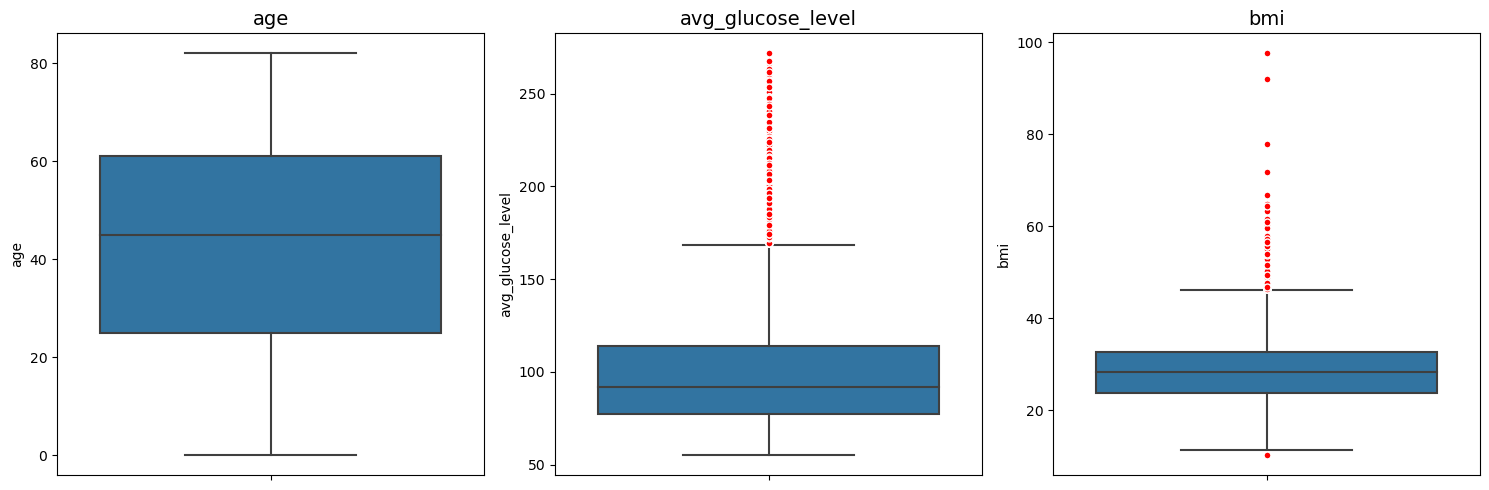

In [9]:
# Dùng biểu đồ boxplot để trực quan hóa sự phân phối của dữ liệu, từ đó tìm kiếm và nhận diện giá trị ngoại lai (outliers) 

# Chọn các cột cần vẽ biểu đồ hộp
selected_columns = ['age', 'avg_glucose_level', 'bmi']

# Chọn dữ liệu tương ứng với các cột đã chọn
selected_data = df[selected_columns]

# Thiết lập kích thước của biểu đồ
plt.figure(figsize=(15, 5))

# Vẽ biểu đồ hộp cho từng cột
for i, column in enumerate(selected_columns):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=selected_data[column], flierprops=dict(markerfacecolor='red', marker='o', markeredgecolor='white'))
    plt.title(column, fontsize=14)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [10]:
new_cols = [col for col in df.columns if col in ['age', 'avg_glucose_level', 'bmi']]
for variable in new_cols:
    # Xác định giá trị ngoại lai sử dụng IQR
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Loại bỏ dữ liệu ngoại lai
    df = df[(df[variable] >= lower_bound) & (df[variable] <= upper_bound)]

In [11]:
# Đổi dữ liệu từ dạng định danh (object) về dạng số
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df["gender"] = lb_make.fit_transform(df["gender"])
df["ever_married"] = lb_make.fit_transform(df["ever_married"])
df["work_type"] = lb_make.fit_transform(df["work_type"])
df["Residence_type"] = lb_make.fit_transform(df["Residence_type"])
df["smoking_status"] = lb_make.fit_transform(df["smoking_status"])
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,31112,1,80.0,0,1,1,2,0,105.92,32.500000,1,1
6,53882,1,74.0,1,1,1,2,0,70.09,27.400000,1,1
7,10434,0,69.0,0,0,0,2,1,94.39,22.800000,1,1
8,27419,0,59.0,0,0,1,2,0,76.15,28.893237,1,1
9,60491,0,78.0,0,0,1,2,1,58.57,24.200000,1,1
10,12109,0,81.0,1,0,1,2,0,80.43,29.700000,1,1
11,12095,0,61.0,0,1,1,0,0,120.46,36.800000,2,1
12,12175,0,54.0,0,0,1,2,1,104.51,27.300000,2,1
15,58202,0,50.0,1,0,1,3,0,167.41,30.900000,1,1
18,27458,0,60.0,0,0,0,2,1,89.22,37.800000,1,1


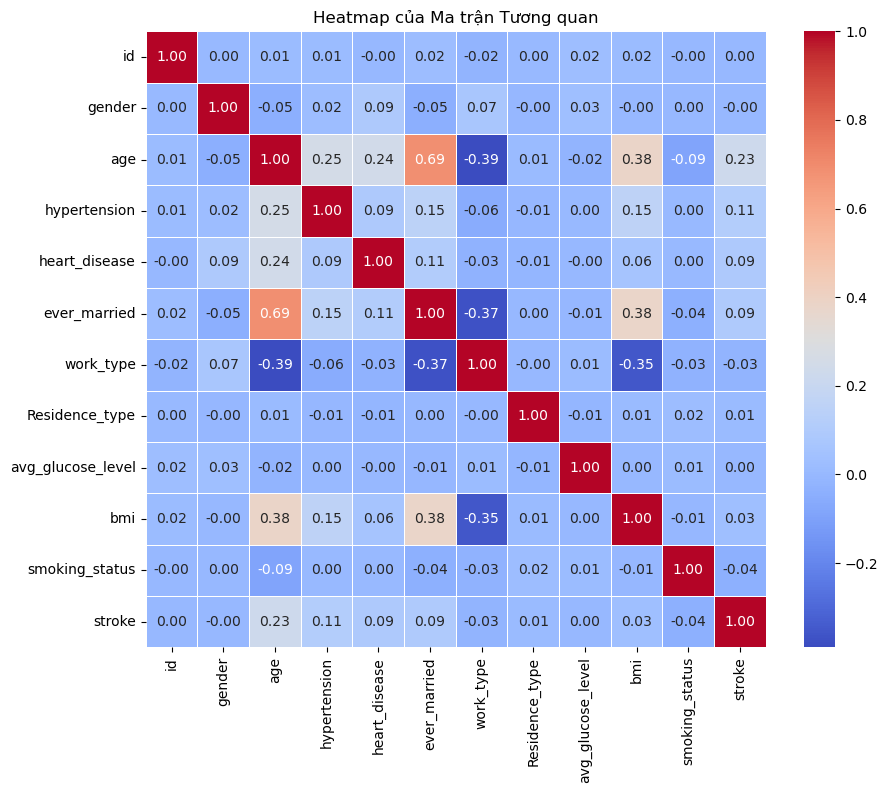

In [12]:
# Tính ma trận tương quan
correlation_matrix = df.corr()

# Vẽ heatmap của ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Heatmap của Ma trận Tương quan")
plt.show()

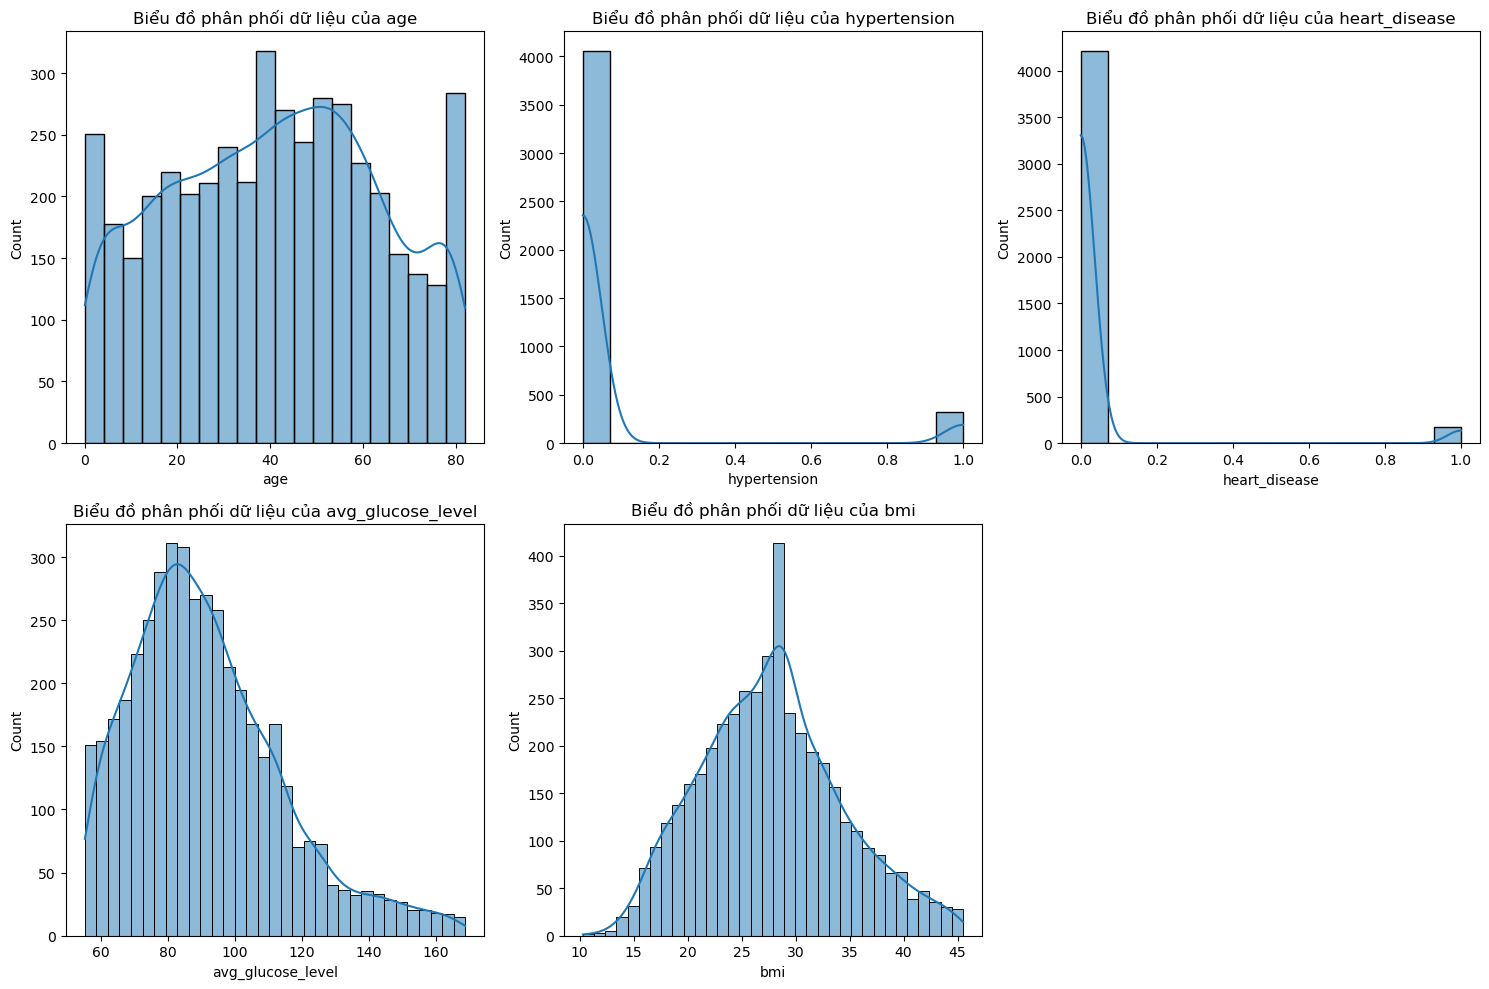

In [13]:
#Biều đồ phân phối dữ liệu của các thuộc tính số 
plt.figure(figsize=(15, 10))
num_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    plt.title(f"Biểu đồ phân phối dữ liệu của {col}")
    sns.histplot(df[col], kde=True)
plt.tight_layout()
plt.show()

NameError: name 'df_upsampled' is not defined

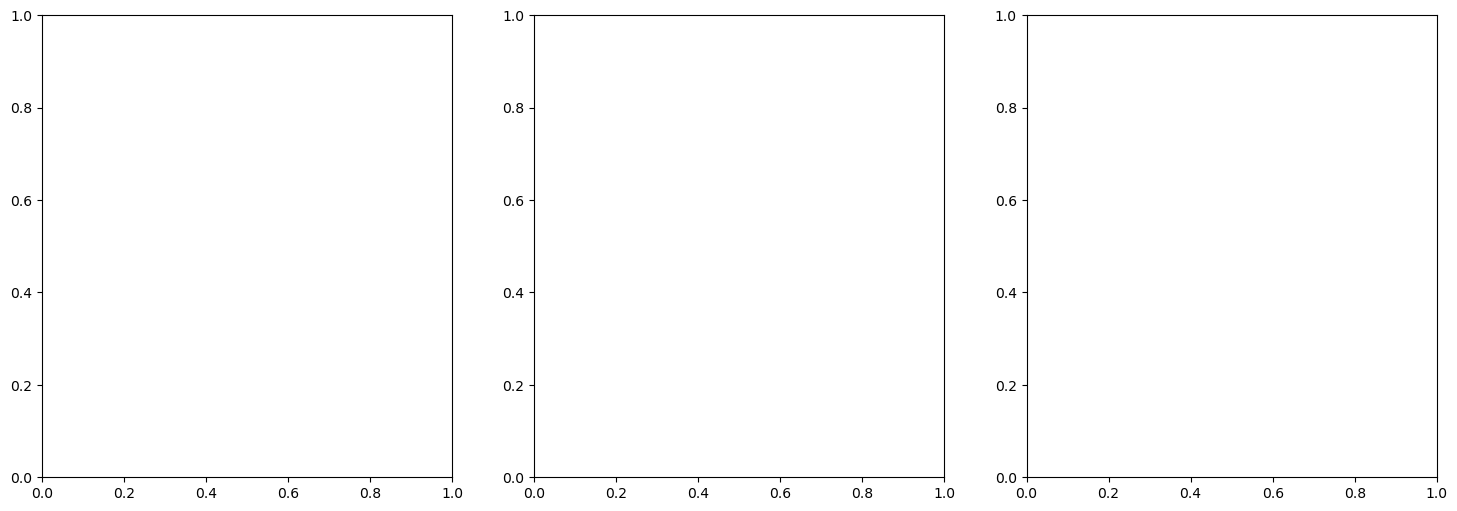

In [14]:
#Biều đồ phân phối dữ liệu của các thuộc tính số

# Các thuộc tính phân loại cần vẽ biểu đồ
cat_cols = ['gender', 'heart_disease', 'smoking_status']

# Tạo biểu đồ với layout 1x3
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
axes = axes.flatten()

# Vẽ biểu đồ phân phối cho từng thuộc tính phân loại theo cột "stroke"
for col, ax in zip(cat_cols, axes):
    sns.countplot(x=col, data=df_upsampled, hue="stroke", palette='Set1', ax=ax)
    ax.set_title(f"Distribution of {col} with Stroke", fontsize=13)
    
    # Hiển thị tỷ lệ phần trăm trên các cột
    total = len(df_upsampled[col])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + (p.get_width() / 2) - 0.1
        y = p.get_y() + p.get_height() + 10
        ax.annotate(percentage, (x, y), size=10, color='black')

# Tăng khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()


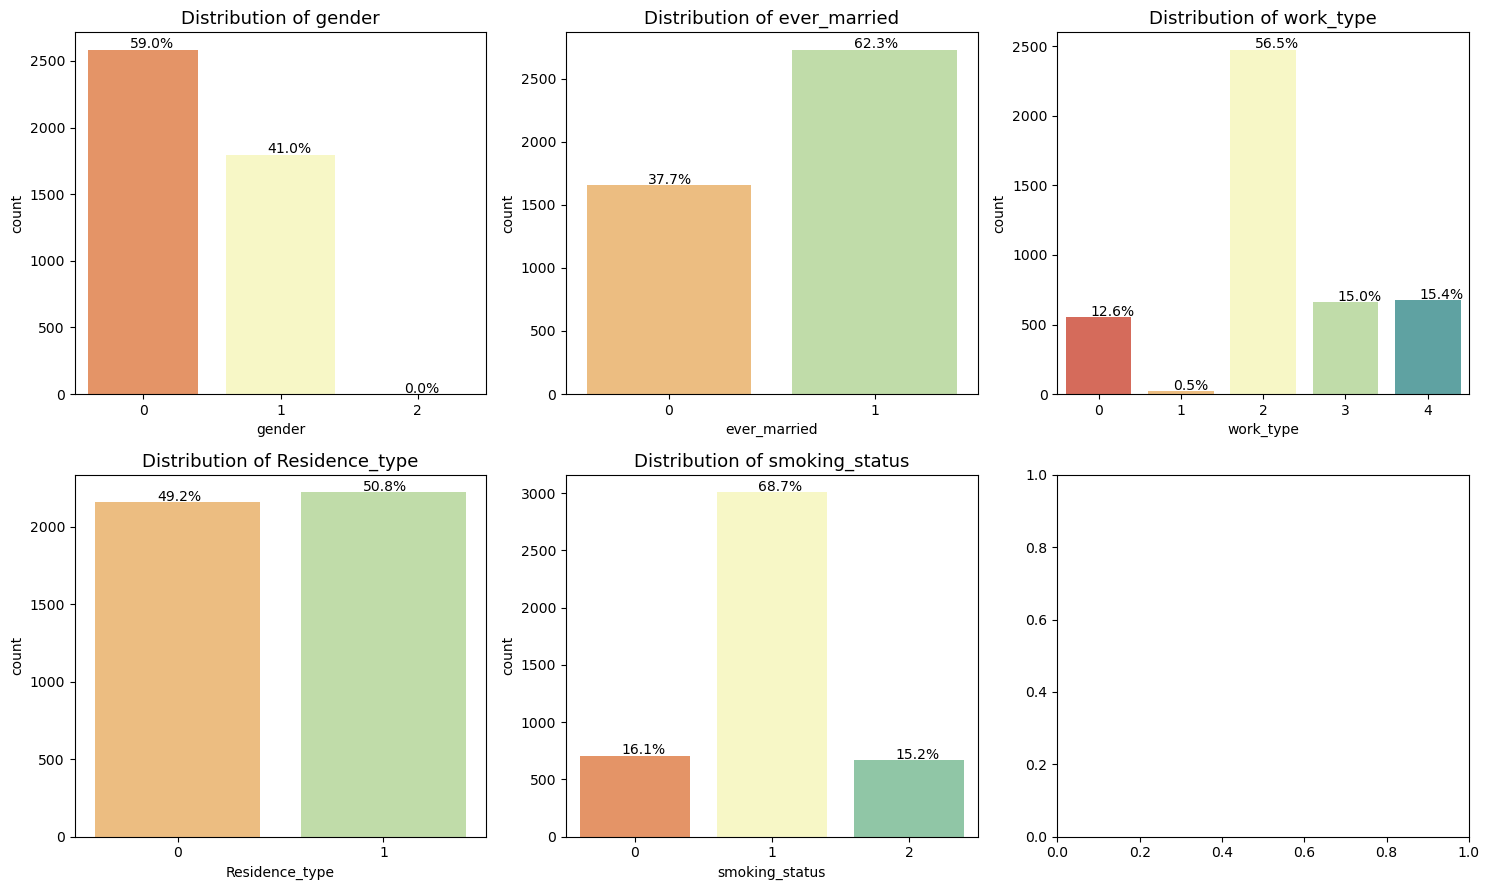

In [148]:
# Biểu đồ phân phối dữ liệu các thuộc tính loại

# Các thuộc tính phân loại cần vẽ biểu đồ
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Kiểm tra và loại bỏ cột chứa giá trị null
cat_cols = [col for col in cat_cols if col not in df.columns[df.isnull().any()]]

# Tạo biểu đồ với layout 2x3
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
axes = axes.flatten()

# Vẽ biểu đồ phân phối cho từng thuộc tính phân loại
for col, ax in zip(cat_cols, axes):
    sns.countplot(data=df, x=col, palette='Spectral', ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=13)
    
    # Hiển thị tỷ lệ phần trăm trên các cột
    total = len(df[col])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + (p.get_width() / 2) - 0.1
        y = p.get_y() + p.get_height() + 10
        ax.annotate(percentage, (x, y), size=10, color='black')

# Tăng khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()


In [149]:
# Thống kê giá trị ở cột Stroke
df['stroke'].value_counts()

0    4219
1     164
Name: stroke, dtype: int64

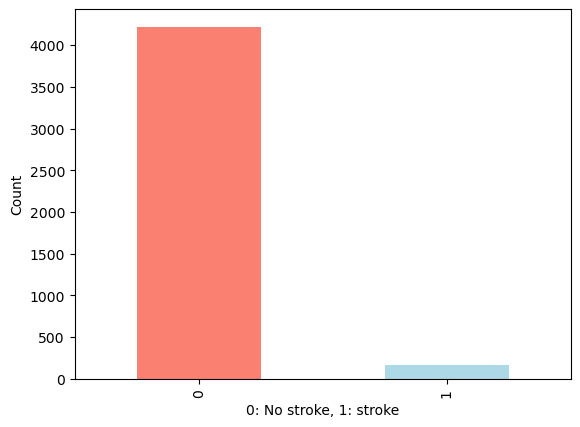

In [150]:
# Thông kê giá trị ở cột Stroke
df['stroke'].value_counts().plot.bar(color=['salmon', 'lightblue']);
plt.xlabel('0: No stroke, 1: stroke')
plt.ylabel('Count');

In [151]:
# Tách dữ liệu thành hai phần: phần chủ yếu (majority) và phần thiểu số (minority) dựa trên cột 'stroke'
df_majority = df[df['stroke'] == 0]
df_minority = df[df['stroke'] == 1]

# Upsample phần thiểu số để cân bằng số lượng mẫu giữa hai phần
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # Lấy mẫu có thay thế
                                 n_samples=3920,  # Số lượng mẫu để kết hợp với phần chủ yếu
                                 random_state=42)  # Đảm bảo kết quả có thể nhắc lại

# Kết hợp phần chủ yếu với phần thiểu số đã được upsampled
df_upsampled = pd.concat([df_minority_upsampled, df_majority])


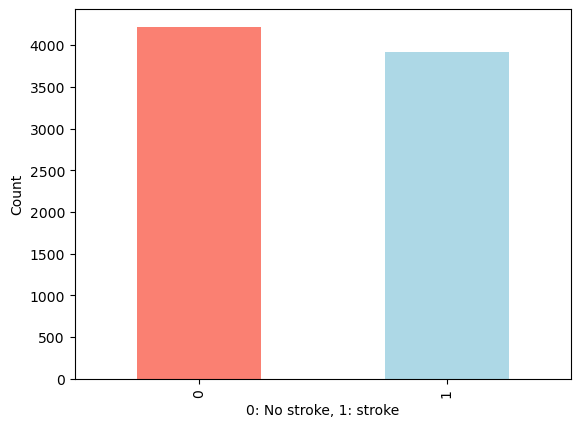

In [152]:
# Giá trị cột stroke sau khi upsampled
df_upsampled['stroke'].value_counts().plot.bar(color=['salmon', 'lightblue']);
plt.xlabel('0: No stroke, 1: stroke')
plt.ylabel('Count');

In [153]:
# Xác định thuộc tính mô tả X và thuộc tính dự đoán y

features = ['gender','age','hypertension','heart_disease','ever_married','work_type',
'Residence_type','avg_glucose_level','bmi','smoking_status']
target = ['stroke']

# Sử dụng df_upsampled thay vì df để xây dựng mô hình
X_upsampled = df_upsampled[features]
y_upsampled = df_upsampled[target]

# Chia dữ liệu thành tập huấn luyện và tập kiểm thử
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(
    X_upsampled, y_upsampled, test_size=0.2, random_state=42
)

# Khai báo và huấn luyện mô hình Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_upsampled, y_train_upsampled)

# Dự đoán trên tập kiểm thử
y_pred_upsampled = model_rf.predict(X_test_upsampled)

# Đánh giá hiệu suất của mô hình
accuracy = accuracy_score(y_test_upsampled, y_pred_upsampled)
confusion_matrix_result = confusion_matrix(y_test_upsampled, y_pred_upsampled)
classification_report_result = classification_report(y_test_upsampled, y_pred_upsampled)

# Hiển thị kết quả
print("Accuracy: ", accuracy)

print("\nConfusion Matrix: \n", confusion_matrix_result)

print("\nClassification Report:\n", classification_report_result)


c:\Users\Tuhp\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy:  0.992014742014742

Confusion Matrix: 
 [[827  13]
 [  0 788]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       840
           1       0.98      1.00      0.99       788

    accuracy                           0.99      1628
   macro avg       0.99      0.99      0.99      1628
weighted avg       0.99      0.99      0.99      1628



In [154]:
# Thay đổi tham số của thuật toán rừng ngẫu nhiên rừng ngẫu nhiên ( n_estimators, max_depth, min_samples_split, min_samples_leaf)

# Khai báo và huấn luyện mô hình Random Forest với các tham số mới
model_rf1 = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
model_rf1.fit(X_train_upsampled, y_train_upsampled)

# Dự đoán trên tập kiểm thử
y_pred_upsampled1 = model_rf1.predict(X_test_upsampled)

# Đánh giá hiệu suất của mô hình
accuracy1 = accuracy_score(y_test_upsampled, y_pred_upsampled1)
confusion_matrix_result1 = confusion_matrix(y_test_upsampled, y_pred_upsampled1)
classification_report_result1 = classification_report(y_test_upsampled, y_pred_upsampled1)

# Hiển thị kết quả
print("Accuracy: ", accuracy1)
print("\nConfusion Matrix: \n", confusion_matrix_result1)
print("\nClassification Report:\n", classification_report_result1)

c:\Users\Tuhp\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy:  0.949017199017199

Confusion Matrix: 
 [[757  83]
 [  0 788]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95       840
           1       0.90      1.00      0.95       788

    accuracy                           0.95      1628
   macro avg       0.95      0.95      0.95      1628
weighted avg       0.95      0.95      0.95      1628



In [155]:
# Thay đổi thuộc tính sử dụng để dự đoán của thuật toán
selected_features_new = ['age', 'hypertension', 'avg_glucose_level', 'bmi']

# Lọc lại dữ liệu với các thuộc tính mới
X_selected_new = X_upsampled[selected_features_new]

# Chia dữ liệu thành tập huấn luyện và tập kiểm thử mới
X_train_selected_new, X_test_selected_new, y_train_selected_new, y_test_selected_new = train_test_split(
    X_selected_new, y_upsampled, test_size=0.2, random_state=42
)

# Khai báo và huấn luyện mô hình Random Forest với các thuộc tính mới
model_rf_selected_new = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_selected_new.fit(X_train_selected_new, y_train_selected_new)

# Dự đoán và đánh giá hiệu suất với các thuộc tính mới
y_pred_selected_new = model_rf_selected_new.predict(X_test_selected_new)
accuracy_selected_new = accuracy_score(y_test_selected_new, y_pred_selected_new)
confusion_matrix_result_selected_new = confusion_matrix(y_test_selected_new, y_pred_selected_new)
classification_report_result_selected_new = classification_report(y_test_selected_new, y_pred_selected_new)

# Hiển thị kết quả với các thuộc tính mới
print("\nAccuracy (Selected Features - New): ", accuracy_selected_new)
print("\nConfusion Matrix (Selected Features - New): \n", confusion_matrix_result_selected_new)
print("\nClassification Report (Selected Features - New):\n", classification_report_result_selected_new)


c:\Users\Tuhp\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Accuracy (Selected Features - New):  0.9815724815724816

Confusion Matrix (Selected Features - New): 
 [[810  30]
 [  0 788]]

Classification Report (Selected Features - New):
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       840
           1       0.96      1.00      0.98       788

    accuracy                           0.98      1628
   macro avg       0.98      0.98      0.98      1628
weighted avg       0.98      0.98      0.98      1628



In [156]:
# Thay đổi thuộc tính sử dụng trong việc dự đoán dựa vào độ quan trọng

# Lấy độ quan trọng của các đặc trưng từ mô hình
feature_importances = model_rf1.feature_importances_

# Tạo DataFrame để hiển thị thông tin
feature_importance_df = pd.DataFrame({'Feature': X_upsampled.columns, 'Importance': feature_importances})

# Sắp xếp theo độ quan trọng giảm dần
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Hiển thị độ quan trọng của các đặc trưng
print("Feature Importance:")
print(feature_importance_df)

# Chọn một ngưỡng độ quan trọng để giữ lại các đặc trưng
threshold = 0.01
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()

# Lọc lại dữ liệu với các đặc trưng quan trọng
X_selected = X_upsampled[selected_features]

# Chia dữ liệu thành tập huấn luyện và tập kiểm thử mới
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(
    X_selected, y_upsampled, test_size=0.2, random_state=42
)

# Huấn luyện mô hình mới
model_rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_selected.fit(X_train_selected, y_train_selected)

# Dự đoán và đánh giá hiệu suất
y_pred_selected = model_rf_selected.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test_selected, y_pred_selected)
confusion_matrix_result_selected = confusion_matrix(y_test_selected, y_pred_selected)
classification_report_result_selected = classification_report(y_test_selected, y_pred_selected)

# Hiển thị kết quả
print("\nAccuracy (Selected Features): ", accuracy_selected)
print("\nConfusion Matrix (Selected Features): \n", confusion_matrix_result_selected)
print("\nClassification Report (Selected Features):\n", classification_report_result_selected)


Feature Importance:
             Feature  Importance
1                age    0.479653
8                bmi    0.167639
7  avg_glucose_level    0.138575
5          work_type    0.053480
4       ever_married    0.048707
2       hypertension    0.031879
9     smoking_status    0.030824
0             gender    0.017549
6     Residence_type    0.017209
3      heart_disease    0.014485


c:\Users\Tuhp\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Accuracy (Selected Features):  0.9944717444717445

Confusion Matrix (Selected Features): 
 [[831   9]
 [  0 788]]

Classification Report (Selected Features):
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       840
           1       0.99      1.00      0.99       788

    accuracy                           0.99      1628
   macro avg       0.99      0.99      0.99      1628
weighted avg       0.99      0.99      0.99      1628

